# Demo of `litholog` functionality using the included demo data

litholog is a package-level extension of agile-geoscience/striplog, with additional features that focus on lithology, and an API that is geared toward facilitating machine learning and quantitative analysis.

The package provides two primary data structures:

- `Bed`
    - stores data from one bed (e.g., top, base, lithology, thickness, grain size, etc).
    - is equivalent to a `striplog.Interval`

- `BedSequence`
    - stores a collection of `Beds` in stratigraphic order 
    - is equivalent to a `striplog.Striplog`

Other utilities include:
- transformations for grain-size data from millimeter (mm) to log2 (a.k.a. Psi) units, which are far easier to work with than mm. 
- calculation of the following metrics at the `BedSequence` level:
    - net-to-gross
    - amalgamation ratio
    - psuedo gamma ray log
    - Hurst statistics (for determining facies clustering)
- default lithology colors

The data provided with this demo come from two papers, and all logs were digitized using the Matlab digitizer included with this release.
- 7 logs from Jobe et al. 2012 ([html](https://doi.org/10.1111/j.1365-3091.2011.01283.x), [pdf](https://www.dropbox.com/s/sgzmc1exd5vjd3h/2012%20Jobe%20et%20al%20Sed-%20Climbing%20ripple%20successions%20in%20turbidite%20systems.pdf?dl=0))
- 11 logs from Jobe et al. 2010 ([html](https://doi.org/10.2110/jsr.2010.092), [pdf](https://www.dropbox.com/s/zo12v3ixm86yt7e/2010%20Jobe%20et%20al%20JSR%20-%20Submarine%20channel%20asymmetry.pdf?dl=0)), 

An example log from that paper is shown here, hand-drawn in vector-art software (left) and plotted with litholog (right):

<img src="../images/example_log.png" alt="Graphic log example" width="400">


In [1]:
# import stuff
import collections
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import litholog
from litholog import utils, Bed
from litholog.sequence import io, BedSequence

from striplog import Component

## Load the demo data from a csv using pandas

This first step uses `utils` within litholog to converts depth-grainsize pairs (e.g., that define a fining-upward profile in a bed) into pandas-friendly arrays. The outputs of this will be the fields shown below (e.g., `depth_m`, `grain_size_mm`). If you have differently formatted csv data, this step may not apply, or you may need a different util.

In [2]:
# Converts 'string' arrays to numpy
transforms = {c : utils.string2array_matlab for c in ['depth_m', 
                                                      'grain_size_mm']}

# Read the demo data
df = pd.read_csv('../data/demo_data.csv', converters=transforms)

# counts and prints the names of the logs in the data file
print(len(df.name.unique()),
      'graphic logs imported:',
      '\n',
      df.name.unique()) 

df.head() # displays the first five rows of data

13 graphic logs imported: 
 ['Karoo krf1' 'Karoo krf2' 'Karoo krf3' 'Karoo krf4' 'Karoo krf5'
 'Magnolia' 'Pukearuhue' 'Sierra del Toro dc1' 'Sierra del Toro dc2'
 'Sierra del Toro flame' 'Sierra del Toro h2o' 'Sierra del Toro ssm'
 'Sierra del Toro wc']


,name,count,collection,eod,eodnum,tops,th,gs_tops_mm,snd_shl,mean_gs_mm,max_gs_mm,ng,ar,depth_m,grain_size_mm
0,Karoo krf1,1,Skoorsteenberg,fan,1,21.042456,0.392483,0.173762,1.0,0.173762,0.173762,0.772615,0.104762,"[21.0425, 20.65]","[0.1738, 0.1738]"
1,Karoo krf1,1,Skoorsteenberg,fan,1,20.649974,0.244327,0.031250,0.0,0.031250,0.031250,0.772615,0.104762,"[20.65, 20.4056]","[0.0583, 0.0583]"
2,Karoo krf1,1,Skoorsteenberg,fan,1,20.405647,0.041588,0.119996,1.0,0.119996,0.119996,0.772615,0.104762,"[20.4056, 20.3641]","[0.12, 0.12]"
3,Karoo krf1,1,Skoorsteenberg,fan,1,20.364059,0.046786,0.031250,0.0,0.031250,0.031250,0.772615,0.104762,"[20.3641, 20.3173]","[0.0583, 0.0583]"
4,Karoo krf1,1,Skoorsteenberg,fan,1,20.317273,0.106568,0.133082,1.0,0.133082,0.133082,0.772615,0.104762,"[20.3173, 20.2107]","[0.1331, 0.1331]"


The variable `df` is just a pandas DataFrame at this point - it hasn't been put into `litholog` format yet. 

Notice that the columns `ng` (net-to-gross) and `ar` (amalgamation ratio) are the same for each graphic log. This csv was processed using Matlab, and `ng` and `ar` were calculated there. Not to worry, `litholog` can also calculate these metrics, which we will show you how to do below. 

### Use `wentworth` to make log2 grain size data 
Before we translate the dataframe into `BedSequences`, let's create a log2 grain-size column. We will use the functionality of `wentworth` to do this, and we will create PSI units instead of PHI units, because they increase with increasing grain size. We simply take the `grain_size_mm` column and translate it to psi units (`grain_size_psi`): 

In [3]:
df['grain_size_psi'] = df.grain_size_mm.apply(lambda x: np.round(litholog.wentworth.gs2psi(x),4))
df.head()

,name,count,collection,eod,eodnum,tops,th,gs_tops_mm,snd_shl,mean_gs_mm,max_gs_mm,ng,ar,depth_m,grain_size_mm,grain_size_psi
0,Karoo krf1,1,Skoorsteenberg,fan,1,21.042456,0.392483,0.173762,1.0,0.173762,0.173762,0.772615,0.104762,"[21.0425, 20.65]","[0.1738, 0.1738]","[-2.5245, -2.5245]"
1,Karoo krf1,1,Skoorsteenberg,fan,1,20.649974,0.244327,0.031250,0.0,0.031250,0.031250,0.772615,0.104762,"[20.65, 20.4056]","[0.0583, 0.0583]","[-4.1004, -4.1004]"
2,Karoo krf1,1,Skoorsteenberg,fan,1,20.405647,0.041588,0.119996,1.0,0.119996,0.119996,0.772615,0.104762,"[20.4056, 20.3641]","[0.12, 0.12]","[-3.0589, -3.0589]"
3,Karoo krf1,1,Skoorsteenberg,fan,1,20.364059,0.046786,0.031250,0.0,0.031250,0.031250,0.772615,0.104762,"[20.3641, 20.3173]","[0.0583, 0.0583]","[-4.1004, -4.1004]"
4,Karoo krf1,1,Skoorsteenberg,fan,1,20.317273,0.106568,0.133082,1.0,0.133082,0.133082,0.772615,0.104762,"[20.3173, 20.2107]","[0.1331, 0.1331]","[-2.9094, -2.9094]"



--- 

---

## Convert dataframe to `BedSequence`s

This is the step that will convert our dataframe into `BedSequences` (equivalent to a `striplog.Striplog`) that contains `Beds` (equivalent to `striplog.Intervals`).

The component map sets the `primary` data for each `Bed` - see other ways to do this in the `litholog_basics.ipynb`

In [4]:
# Columns shared by whole sequences (i.e., shared by an entire graphic log)
METACOLS = ['name', 'collection', 'ng', 'ar']

# Columns of bed-level data, including the psi column we just made
DATACOLS = ['th', 'gs_tops_mm', 'snd_shl', 'depth_m',
            'gs_tops_mm', 'mean_gs_mm', 'max_gs_mm', 'grain_size_mm','grain_size_psi']

# Convert dataframe to a list of `BedSequence`s
seqs = []
for group, values in df.groupby('name'):
    seqs.append(
        BedSequence.from_dataframe(
            values, 
            thickcol='th',
            component_map=litholog.defaults.DEFAULT_COMPONENT_MAP,
            metacols=METACOLS,
            datacols=DATACOLS,
        )
    )
    
# Show name + eod + number of beds of each
print(len(seqs),'logs imported as BedSequences')

[(s.metadata['name'], len(s),'Beds') for s in seqs]

13 logs imported as BedSequences


[('Karoo krf1', 105, 'Beds'),
 ('Karoo krf2', 20, 'Beds'),
 ('Karoo krf3', 42, 'Beds'),
 ('Karoo krf4', 15, 'Beds'),
 ('Karoo krf5', 51, 'Beds'),
 ('Magnolia', 181, 'Beds'),
 ('Pukearuhue', 211, 'Beds'),
 ('Sierra del Toro dc1', 166, 'Beds'),
 ('Sierra del Toro dc2', 44, 'Beds'),
 ('Sierra del Toro flame', 63, 'Beds'),
 ('Sierra del Toro h2o', 66, 'Beds'),
 ('Sierra del Toro ssm', 54, 'Beds'),
 ('Sierra del Toro wc', 38, 'Beds')]

In [5]:
# nice way to parse data to get only BedSequences with more than 30 sand beds
thirty = list(filter(lambda s: len(s.get_field('th', 'sand')) >= 30, seqs))

# display the names
[(s.metadata['name']) for s in thirty]

['Karoo krf1',
 'Karoo krf5',
 'Magnolia',
 'Pukearuhue',
 'Sierra del Toro dc1',
 'Sierra del Toro h2o']

## Basic data retrieval from a `BedSequence` and its `Bed`s
### `BedSequence`

In [6]:
# Choose two logs to use as examples
magnolia = seqs[5] # a core description from the Gulf of Mexico

testseq = seqs[-2] # an outcrop log from Chile

# see what they look like
[magnolia, testseq]

[Striplog(181 Intervals, start=0.0, stop=59.999347598),
 Striplog(54 Intervals, start=0.0, stop=65.99495201)]

In [ ]:
# Order is important for logs, and it is either elevation or depth
print('Magnolia is a core so it has order:',magnolia.order,'\n'
      'all other demo BedSequences are elevation ordered')

# here are all the orders:
[[s.order, s.metadata['name']] for s in seqs]

In [ ]:
# access the base and top of a BedSequence
testseq.start, testseq.stop

In [ ]:
# Access the metadata
print(testseq.metadata)

testseq.metadata['ng']

In [ ]:
# Access the `data` fields, which are numpy arrays
print(type(testseq.get_field('th')))
print(testseq.get_field('th'))

In [ ]:
print('total thickness is',testseq.get_field('th').sum(),'meters')
print('maximum Bed thickness is',testseq.max_field('th'),'meters')
print('minimum Bed thickness is',testseq.min_field('th'),'meters')
print('maximum grain size is',testseq.max_field('grain_size_mm'),'mm')

### `Bed`
Now let's take a look at one `Bed`. All `Beds` must have a `top`, `base`, and `data`, which can be array or dict-like. You will note that there is a `primary` field as well, which is defined using the `Component` from `striplog` or a component map, as we did above

In [ ]:
testseq[-1] # In elevation order, the lowermost bed is the last one [-1] instead of the first one [0]

In [ ]:
# if a log is elevation-ordered, the last bed should have a base at zero
testseq[-1].base

In [ ]:
# what about a depth-oprdered core? 
magnolia[0].top
# if this core was really in depth units (e.g., measured depth), 
# the top would be whatever depth the core top was. In this case, 
# the depths were manually transformed to meters prior to digitization

In [ ]:
print(testseq[-1].top.upper) # see the striplog Interval class for info on upper, middle, and lower
print(testseq[-1].primary.lithology)
print(testseq[-1].data['mean_gs_mm'])
print('Mean grain size:',litholog.wentworth.gs2name(testseq[-1].data['mean_gs_mm']))
print('Grain size at top of bed:',litholog.wentworth.gs2name(testseq[-1].data['gs_tops_mm']))

In [ ]:
# Let's look at the uppermost bed now
print(testseq[0].lithology)
print(testseq[0].summary())

In [ ]:
# get one bed top using an index
print(testseq[0].top.middle)

# get the first five bed tops using list comprehension (see striplog docs for attributes of top and base (e.g., base, middle, upper))
print('first five',[bed.top.middle for bed in testseq[0:5]])

# or you can build a simple loop
for bed in testseq[0:5]:
    print(bed.top.middle)

In [ ]:
# lets look at a covered interval - note  the NaNs for grain size
testseq[-11]

## Plotting
### Basic plotting

In [ ]:
# the most simple plot, but doesnt include any bed-level grain size data (e.g., fining-upwards)
testseq.plot()

### Including intra-`Bed` grain-size data in a plot

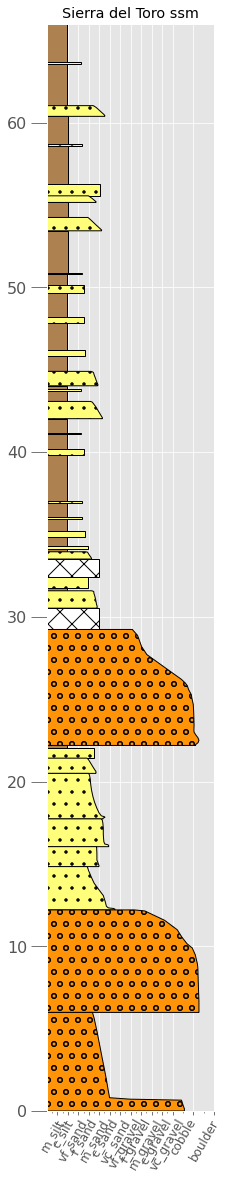

In [7]:
# here is a little nicer way to plot it that includes the grain size data for each bed

fig, ax = plt.subplots(figsize=[3,20])

testseq.plot(ax=ax,
             legend=litholog.defaults.litholegend,
             width_field='grain_size_psi',
             depth_field='depth_m',
             wentworth='fine'
            )

ax.set_title(testseq.metadata['name']);

# can save it by uncommenting this line
#plt.savefig('testseq.svg')

#### Extracting fining-upwards profiles from a `Bed`

In [ ]:
gs=testseq[-1].data['grain_size_psi'] # get just one field from a Bed
de=testseq[-1].data['depth_m'] 

plt.plot(gs,de,'k')
if testseq.order=='depth': 
    plt.gca().invert_yaxis()
    print('depth ordered')
    
plt.title('Fining upward trend from one Bed');

In [ ]:
# and we can do it for all beds that are classified as `sand`:
fig, ax = plt.subplots()
for bed in testseq:
    if bed.lithology=='sand':
        gs=bed.data['grain_size_psi']
        
        de=bed.data['depth_m']
        de=np.max(de)-de # normalize to zero so they will all plot together
        if testseq.order=='elevation':
            de=np.flip(de)
        ax.plot(gs,de,'k')

### Flipping the order of a BedSequence

In [ ]:
testseq.order

In [ ]:
# flipping to depth order (Note - this doesnt change the BedSequence at all, just replots it)
testseq.flip_convention(depth_key='depth_m').plot(
    legend=litholog.defaults.litholegend, 
    fig_width=3, 
    aspect=5,
    width_field='grain_size_psi',
    depth_field='depth_m',
    wentworth='coarse');

# note that this doesn't change the order, it just creates the plot
print(testseq.order)

In [ ]:
# Now let's flip Magnolia from depth to elevation
magnolia.flip_convention(depth_key='depth_m').plot(
    legend=litholog.defaults.litholegend, 
    fig_width=3, 
    aspect=5, 
    width_field='grain_size_psi',
    depth_field='depth_m',
    wentworth='coarse')

### Plot mulitple logs at the same scale (i.e., a correlation panel)
By using matplotlib's `subplots`, we can plot several `BedSequences` at the same scale, which is commonly done for many purposes, including creating correlation panels. Note that this functionality could be vastly improved upon, but it'll do for now.

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(10,20))

seqs[-4].plot(legend=litholog.defaults.litholegend,
             width_field='grain_size_psi',
             depth_field='depth_m',
             ax=ax[0])

seqs[-3].plot(legend=litholog.defaults.litholegend,
             width_field='grain_size_psi',
             depth_field='depth_m',
             ax=ax[1])

seqs[-2].plot(legend=litholog.defaults.litholegend,
             width_field='grain_size_psi',
             depth_field='depth_m',
             ax=ax[2])

ax[0].set_ylim([0,110]); # could clean this up into a function to recommend ylim, but for now it's fine

## Save out images

In [ ]:
for i,s in enumerate(seqs):
    print(i, end=',')
    fig, ax = plt.subplots(figsize=[5,25])
    s.plot(ax=ax,
             legend=litholog.defaults.litholegend,
             width_field='grain_size_psi',
             depth_field='depth_m',
             wentworth='fine'
            )
    title_str = s.metadata['name']
    ax.set_title(title_str);
    plt.tight_layout()
    fig.savefig(title_str+'.png')
    plt.close(fig)

## Statistics for BedSequences

In [ ]:
print(testseq.metadata)

# Properties computed on the fly
print(testseq.net_to_gross,';',testseq.amalgamation_ratio)

print('N:G from Matlab:',round(testseq.metadata['ng'],3),'\n',
      'N:G from litholog:',round(testseq.net_to_gross,3))

In [ ]:
# Hurst statistics
print(testseq.hurst_K('th', 'sand'))

# Returns (D, p, hurst_K)
testseq.hurst_D('th', 'sand', nsamples=10000)

## Pseudo gamma-ray log
We include functionality to create a simple pseudo GR curve of a `BedSequence`.

First, let's define some functions to help us make this plot. Note, these functions only really work when you are plotting the same log (i.e., the log itself and the pseudo GR) - if you are plotting two logs together, see above example... 

In [ ]:
def suggest_figsize(sequence, aspect=10):
    """
    Defining default a total thickness -> figure size mapping.
    """
    suggest_h = max(10, min(sequence.cum, 50))
    suggest_w = suggest_h / aspect
    return (suggest_w, suggest_h)

def strip_fig_extra_columns(ax_num, sequence, ncols, exxon_style=True, figsize=None, aspect=10):
    """
    Creates a fig with `ncol` axes and plots `sequence` on one of them.
    If `exxon_style`, plots `sequence` on first axis, otherwise last axis.
    Returns
    -------
    fig, ax
    """
    w, h = suggest_figsize(sequence, aspect=aspect)
    print(w, h)

    fig, ax = plt.subplots(ncols=ncols, sharey=True, figsize=(w*ncols, h))
    #fig.subplots_adjust(wspace=0.)

    sequence.plot(legend=litholog.defaults.litholegend,
                  width_field='grain_size_psi',
                  depth_field='depth_m',
                  ax=ax[ax_num])

    return fig, ax

In [ ]:
# Now let's plot it
# The values you see are the defaults:
ds, pgr = testseq.pseudo_gamma_simple(
    gs_field='grain_size_mm',
    depth_field='depth_m',
    resolution=0.2,
    gs_cutoff=0.0625,
    gamma_range=(30, 180),
    sigma=0.1,
    noise=10.
)

fig, ax = strip_fig_extra_columns(0, testseq, 2, aspect=9)

cutoff = 100

ax[1].plot(pgr, ds, 'k')
ax[1].fill_betweenx(ds, pgr, np.repeat(cutoff, ds.size), where=(pgr<cutoff), color='yellow')

ax[1].set_xlim([0,200])

## Other methods not demonstrated here

There are a few methods that we didn't demonstrate here, including a `resample_data` , which is handy for depth-based resampling of grain size data (e.g., to export into Petrel or other software). 

We would love your feedback on `litholog` and pull-requests to make it better!